# 分心驾驶数据分析

训练一个神经网络分类器，对分析驾驶数据进行分类和预测。

In [164]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载和准备数据


In [165]:
data_path = "data.xlsx"
feature_name = ['speed', 'acc', 'wheel', 'pedal']
name_to_sheet = {'speed':'Sheet2', \
         'acc':  'Sheet3', \
         'wheel':'Sheet4', \
         'pedal':'Sheet5'}
         
deviation = pd.read_excel(data_path, list(name_to_sheet.values()))
all_feature = pd.DataFrame()
n_classes = 2

In [166]:
index = name_to_sheet['pedal']
deviation[index].head()

,事项,油门踏板标准差,事项.1,油门踏板标准差.1
0,平稳行驶1,0.0473,饮水驾驶次任务1,0.0637
1,平稳行驶2,0.0299,饮水驾驶次任务2,0.0465
2,平稳行驶3,0.0114,饮水驾驶次任务3,0.0601
3,平稳行驶4,0.0272,饮水驾驶次任务4,0.0606
4,平稳行驶5,0.0285,饮水驾驶次任务5,0.0763


### 数据简介

此数据集包括了平稳驾驶、饮水驾驶各180次的数据，数据特征为车速标准差(speed)、加速度标准差(acc)、方向盘转角标准差(wheel)、油门踏板标准差(pedal)。改变上方的索引，可以看到不同特征前几行的数据。

下图绘制出了各特征的正负样本分布图。

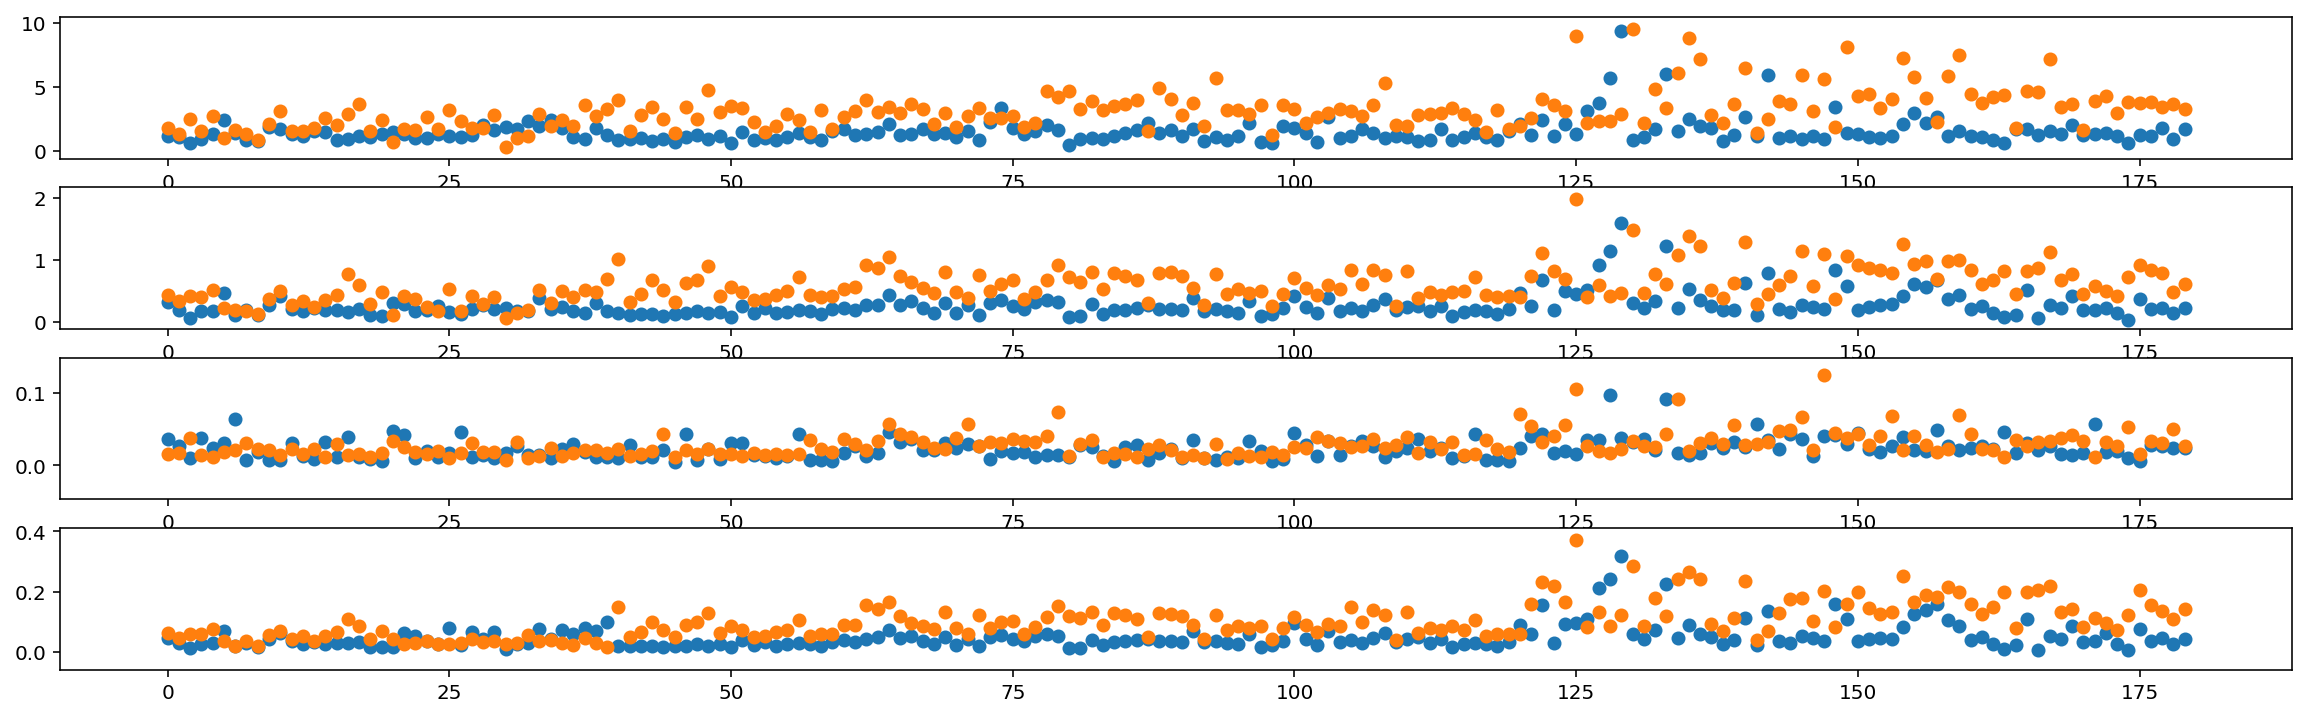

In [167]:
fig, ax = plt.subplots(4,1,figsize=(20,6))

index = name_to_sheet['speed']
frame = deviation[index]
col = frame.columns
ax[0].scatter(frame.index, frame[col[1]])
ax[0].scatter(frame.index, frame[col[3]])

index = name_to_sheet['acc']
frame = deviation[index]
col = frame.columns
ax[1].scatter(frame.index, frame[col[1]])
ax[1].scatter(frame.index, frame[col[3]])

index = name_to_sheet['wheel']
frame = deviation[index]
col = frame.columns
ax[2].scatter(frame.index, frame[col[1]])
ax[2].scatter(frame.index, frame[col[3]])

index = name_to_sheet['pedal']
frame = deviation[index]
col = frame.columns
ax[3].scatter(frame.index, frame[col[1]])
ax[3].scatter(frame.index, frame[col[3]])

### 数据汇总

将各个特征汇总到一张表里

In [168]:
frames = [deviation[name_to_sheet[name]] for name in feature_name]
all_feature = pd.concat(frames, axis = 1)
col = all_feature.columns
fields_to_drop = [col[0], col[2]]
all_feature = all_feature.drop(fields_to_drop, axis = 1)

In [169]:
all_feature.head()

,车速标准差,车速标准差.1,加速度标准差,加速度标准差.1,方向盘转角标准差,方向盘转角标准差.1,油门踏板标准差,油门踏板标准差.1
0,1.1814,1.7446,0.3334,0.4347,0.0373,0.0160,0.0473,0.0637
1,1.1085,1.3493,0.2059,0.3361,0.0277,0.0177,0.0299,0.0465
2,0.5997,2.5127,0.0748,0.4258,0.0103,0.0383,0.0114,0.0601
3,0.8835,1.5842,0.1834,0.4031,0.0382,0.0147,0.0272,0.0606
4,1.2829,2.6933,0.1849,0.5209,0.0248,0.0120,0.0285,0.0763


In [170]:
col = all_feature.columns
positive_feature = all_feature[col[::2]]
negative_feature = all_feature.drop(col[::2], axis=1)

#修改列的名字
col = positive_feature.columns
name_dict = {old:new for old,new in zip(list(col),feature_name)}
positive_feature = positive_feature.rename(index = str, columns = name_dict)

col = negative_feature.columns
name_dict = {old:new for old,new in zip(list(col),feature_name)}
negative_feature = negative_feature.rename(index = str, columns = name_dict)

#增加政府样本的值
positive_feature['y'] = 1
negative_feature['y'] = 0

#将正负样本拼接到一起
all_feature = pd.concat([positive_feature, negative_feature])

In [171]:
positive_feature.head()

,speed,acc,wheel,pedal,y
0,1.1814,0.3334,0.0373,0.0473,1
1,1.1085,0.2059,0.0277,0.0299,1
2,0.5997,0.0748,0.0103,0.0114,1
3,0.8835,0.1834,0.0382,0.0272,1
4,1.2829,0.1849,0.0248,0.0285,1


In [172]:
negative_feature.head()

,speed,acc,wheel,pedal,y
0,1.7446,0.4347,0.0160,0.0637,0
1,1.3493,0.3361,0.0177,0.0465,0
2,2.5127,0.4258,0.0383,0.0601,0
3,1.5842,0.4031,0.0147,0.0606,0
4,2.6933,0.5209,0.0120,0.0763,0


In [173]:
all_feature[178:182]

,speed,acc,wheel,pedal,y
178,0.8990,0.1529,0.0249,0.0255,1
179,1.6905,0.2252,0.0238,0.0414,1
0,1.7446,0.4347,0.0160,0.0637,0
1,1.3493,0.3361,0.0177,0.0465,0


### 调整目标变量

为了更轻松地训练网络，对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。

我们会保存换算因子，以便当我们使用网络进行预测时可以还原数据。

In [174]:
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in feature_name:
    mean, std = all_feature[each].mean(), all_feature[each].std()
    scaled_features[each] = [mean, std]
    all_feature.loc[:, each] = (all_feature[each] - mean)/std

In [175]:
all_feature

,speed,acc,wheel,pedal,y
0,-0.750637,-0.362123,0.702985,-0.498724,1
1,-0.797790,-0.795078,0.096954,-0.797022,1
2,-1.126890,-1.240257,-1.001476,-1.114177,1
3,-0.943323,-0.871481,0.759801,-0.843309,1
4,-0.684985,-0.866388,-0.086117,-0.821023,1
5,0.038609,0.107505,0.292652,-0.104423,1
6,-0.628130,-1.066396,2.413760,-0.997601,1
7,-0.968096,-0.835487,-1.178235,-0.800450,1
8,-1.024758,-1.112578,-0.490138,-1.018173,1
9,-0.304851,-0.529872,-1.134046,-0.555298,1


### 将数据拆分为训练、测试和验证数据集

从这里开始，使用numpy的数据类型

In [218]:
#定义一个划分数据集的系数
prob = 0.8

#先打乱一下数据
data = all_feature.values
np.random.shuffle(data)

#再把输入和标签分开
features = data[:,:-1]
labels = data[:,-1]
labels = labels.astype(int)

# 获取训练数据集
all_len = features.shape[0]
train_len = int(all_len*prob)
train_x, valid_x = features[:train_len], features[train_len:]
train_y, valid_y = labels[:train_len], labels[train_len:]

#获取验证、测试数据集
valid_len = int(valid_x.shape[0]*0.5)
valid_x, test_x = valid_x[:valid_len], valid_x[valid_len:]
valid_y, test_y = valid_y[:valid_len], valid_y[valid_len:]

### ONE-HOT编码

实现一个对标签进行独热编码的函数

In [219]:
def one_hot(labels, n_classes):
    arr = np.eye(n_classes)
    return arr[labels]
    

## 开始构建网络

该网络有两个层级，一个隐藏层和一个输出层。隐藏层节点数量可变，无激活函数；输出层节点数量和类别数量一致。
  

### 输入层


In [220]:
import tensorflow as tf

def get_feature_input():
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, [None, None], "x")


def get_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, [None, n_classes], "y")


def get_learning_rate_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, name = "keep_prob")

### 添加层数的函数

In [231]:
def add_layer(inputs, n_feature=2, output_size=20):
    """
    添加一层，暂时不需要激活函数
    : inputs: 该层的输入
    : output_size: 输入的size
    """
    weights = tf.Variable(tf.truncated_normal([n_feature ,output_size], stddev=0.1))
    bias = tf.Variable(tf.zeros(output_size))
    output = tf.add(tf.matmul(inputs, weights), bias)
    
    return output

### 定义损失、优化器、正确率评估

In [240]:
def build_network(x, y, n_feature, hidden_size, lr):
    """
    
    """
    hidden_output = add_layer(x, n_feature, hidden_size)
    logits = add_layer(hidden_output, hidden_size, n_classes)

    softmax = tf.nn.softmax(logits)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    cost = tf.reduce_mean(cross_entropy)

    optimizer = tf.train.GradientDescentOptimizer(lr)
    train_step = optimizer.minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(logits,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    return logits, cost, train_step, accuracy



## 训练网络

现在你将设置网络的超参数。策略是设置的超参数使训练集上的错误很小但是数据不会过拟合。如果网络训练时间太长，或者有太多的隐藏节点，可能就会过于针对特定训练集，无法泛化到验证数据集。即当训练集的损失降低时，验证集的损失将开始增大。

你还将采用随机梯度下降 (SGD) 方法训练网络。对于每次训练，都获取随机样本数据，而不是整个数据集。与普通梯度下降相比，训练次数要更多，但是每次时间更短。这样的话，网络训练效率更高。稍后你将详细了解 SGD。


### 选择迭代次数

也就是训练网络时从训练数据中抽样的批次数量。迭代次数越多，模型就与数据越拟合。但是，如果迭代次数太多，模型就无法很好地泛化到其他数据，这叫做过拟合。你需要选择一个使训练损失很低并且验证损失保持中等水平的数字。当你开始过拟合时，你会发现训练损失继续下降，但是验证损失开始上升。

### 选择学习速率

速率可以调整权重更新幅度。如果速率太大，权重就会太大，导致网络无法与数据相拟合。建议从 0.1 开始。如果网络在与数据拟合时遇到问题，尝试降低学习速率。注意，学习速率越低，权重更新的步长就越小，神经网络收敛的时间就越长。


### 选择隐藏节点数量

隐藏节点越多，模型的预测结果就越准确。尝试不同的隐藏节点的数量，看看对性能有何影响。你可以查看损失字典，寻找网络性能指标。如果隐藏单元的数量太少，那么模型就没有足够的空间进行学习，如果太多，则学习方向就有太多的选择。选择隐藏单元数量的技巧在于找到合适的平衡点。

In [256]:
import sys

### Set the hyperparameters here ###
iterations = 1000
learning_rate = 0.001
hidden_size = 50
batch_size = train_x.shape[0]

x = get_feature_input()
y = get_label_input(n_classes)
lr = get_learning_rate_input()

n_feature = train_x.shape[1]
logits, cost, train_step, accuracy = build_network(x, y, n_feature, hidden_size, lr)
losses = []
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for ii in range(iterations):
        feed = {x:train_x, \
                y:one_hot(train_y,2), \
                lr:learning_rate}
        loss,_ = sess.run([cost, train_step], feed_dict = feed)
        
        feed = {x:valid_x, \
                y:one_hot(valid_y,2), \
                lr:learning_rate}
        acc = sess.run(accuracy, feed_dict = feed)
        
        print("\rTraining loss: " + str(loss)[:5] \
                         + " ... Validation accuracy: " + str(acc)[:5])

        losses.append(loss)

Training loss: 0.686 ... Validation accuracy: 0.888
Training loss: 0.609 ... Validation accuracy: 0.888
Training loss: 0.574 ... Validation accuracy: 0.888
Training loss: 0.553 ... Validation accuracy: 0.888
Training loss: 0.539 ... Validation accuracy: 0.888
Training loss: 0.530 ... Validation accuracy: 0.888
Training loss: 0.523 ... Validation accuracy: 0.888
Training loss: 0.518 ... Validation accuracy: 0.888
Training loss: 0.513 ... Validation accuracy: 0.888
Training loss: 0.510 ... Validation accuracy: 0.888
Training loss: 0.507 ... Validation accuracy: 0.888
Training loss: 0.505 ... Validation accuracy: 0.888
Training loss: 0.503 ... Validation accuracy: 0.888
Training loss: 0.501 ... Validation accuracy: 0.888
Training loss: 0.499 ... Validation accuracy: 0.888
Training loss: 0.498 ... Validation accuracy: 0.888
Training loss: 0.496 ... Validation accuracy: 0.888
Training loss: 0.495 ... Validation accuracy: 0.888
Training loss: 0.494 ... Validation accuracy: 0.888
Training los

Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.449 ... Validation accuracy: 0.888
Training loss: 0.448 ... Validation accuracy: 0.888
Training loss: 0.448 ... Validation accuracy: 0.888
Training loss: 0.448 ... Validation accuracy: 0.888
Training loss: 0.448 ... Validation accuracy: 0.888
Training loss: 0.448 ... Validation accuracy: 0.888
Training los

Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training los

Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training los

Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training los

Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training loss: 0.446 ... Validation accuracy: 0.861
Training los

In [258]:
losses

[0.68672055,
 0.60982776,
 0.57413816,
 0.55319715,
 0.53958291,
 0.5301522,
 0.52328247,
 0.5180552,
 0.51392424,
 0.5105536,
 0.50773031,
 0.50531495,
 0.50321257,
 0.5013572,
 0.49970043,
 0.49820635,
 0.49684757,
 0.49560198,
 0.49445254,
 0.49338496,
 0.49238765,
 0.49145114,
 0.49056715,
 0.48972905,
 0.48893106,
 0.48816839,
 0.48743683,
 0.4867329,
 0.48605359,
 0.48539624,
 0.48475891,
 0.48413932,
 0.48353618,
 0.48294795,
 0.48237345,
 0.48181152,
 0.48126146,
 0.48072243,
 0.48019376,
 0.47967476,
 0.47916508,
 0.47866428,
 0.47817177,
 0.47768763,
 0.47721106,
 0.47674212,
 0.47628054,
 0.47582605,
 0.47537851,
 0.4749378,
 0.47450367,
 0.47407594,
 0.47365469,
 0.47323957,
 0.47283065,
 0.47242779,
 0.47203076,
 0.47163942,
 0.47125399,
 0.47087425,
 0.47049987,
 0.47013104,
 0.46976757,
 0.46940941,
 0.46905655,
 0.46870878,
 0.46836603,
 0.46802834,
 0.46769556,
 0.46736771,
 0.4670445,
 0.46672609,
 0.46641222,
 0.46610302,
 0.46579826,
 0.46549791,
 0.46520191,
 0.464

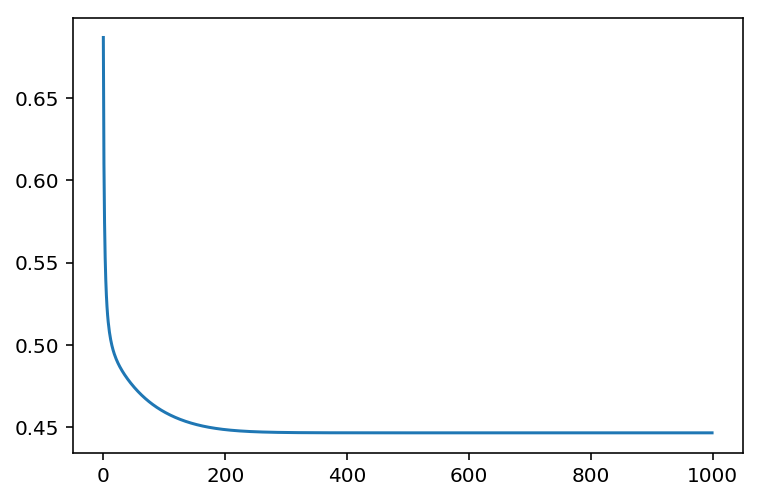

In [259]:
plt.plot(losses, label='Training loss')

## 检查预测结果

使用测试数据看看网络对数据建模的效果如何。如果完全错了，请确保网络中的每步都正确实现。

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)